In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import json
import os
from datetime import datetime
from tensorflow.keras.datasets import mnist
from tensorflow import keras 
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Flatten, Reshape, concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose

In [11]:
# Parameters
batch_size = 32
num_classes = 10   # normal, disarranged etc
hidden_dim = 128
input_width = 224
input_height = 224

epochs = 150

In [12]:
# Load preprocessed data
data = np.load('../Processed Input Images/preprocessed_data_cvae_train_224x224.npz')
x_train, y_train = data['x_train'], data['y_train']
x_test, y_test = data['x_test'], data['y_test']

# Convert labels to OHC
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Map numeric labels to text labels
data_dir = '../Raw Input Images'
class_names = sorted(os.listdir(data_dir))
y_train_text = [class_names[int(label)] for label in y_train]
y_test_text = [class_names[int(label)] for label in y_test]


In [13]:
def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def noiser(args):
    global mean, log_var
    mean, log_var = args
    # Get the actual batch size from the input tensor
    actual_batch_size = tf.shape(mean)[0]
    N = tf.random.normal(shape=(actual_batch_size, hidden_dim), mean=0., stddev=1.0)
    return tf.exp(log_var / 2) * N + mean

In [14]:
# Define inputs
input_image = keras.Input(shape=(input_width, input_height, 1), name='input_image')
lb = keras.Input(shape=(num_classes,), name='label_input')

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Flatten and concatenate
x = keras.layers.Flatten()(x)
x = keras.layers.concatenate([x, lb])

# Dense layers
x = Dense(512, activation='relu')(x)
x = dropout_and_batchnorm(x)
x = Dense(256, activation='relu')(x)
x = dropout_and_batchnorm(x)

# Mean and log_var
mean = keras.layers.Dense(hidden_dim, name='mean')(x)
log_var = keras.layers.Dense(hidden_dim, name='log_var')(x)
h = keras.layers.Lambda(noiser, output_shape=(hidden_dim,), name='z')([mean, log_var])

# Create the encoder model
encoder = keras.Model([input_image, lb], h, name='encoder')

In [15]:
# Decoder
input_dec = Input(shape=(hidden_dim,))
lb_dec = Input(shape=(num_classes,))

# Dense layers
d = Concatenate()([input_dec, lb_dec])
d = Dense(256, activation='relu')(d)
d = dropout_and_batchnorm(d)
d = Dense(512, activation='relu')(d)
d = dropout_and_batchnorm(d)
d = Dense(28 * 28 * 64, activation='relu')(d)
d = Reshape((28, 28, 64))(d)

# Transposed convolution layers
d = Conv2D(64, (3, 3), activation='relu', padding='same')(d)
d = UpSampling2D((2, 2))(d) # 56x56
d = Conv2D(32, (3, 3), activation='relu', padding='same')(d)
d = UpSampling2D((2, 2))(d) # 112x112
d = Conv2D(16, (3, 3), activation='relu', padding='same')(d)
d = UpSampling2D((2, 2))(d) # 224x224

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)
decoder = keras.Model([input_dec, lb_dec], decoded, name="decoder")

In [16]:
def vae_loss(x, y):
    # Get the actual batch size from the input tensor
    actual_batch_size = tf.shape(x)[0]
    x = tf.reshape(x, shape=(actual_batch_size, input_width*input_height))
    y = tf.reshape(y, shape=(actual_batch_size, input_width*input_height))
    
    # Compute reconstruction loss
    reconstruction_loss = tf.reduce_sum(tf.square(x-y), axis=-1)
    
    # Compute KL divergence
    kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    
    # Return mean loss
    return tf.reduce_mean(reconstruction_loss + kl_loss)

In [17]:
# CVAE model (only h is passed to the decoder)
cvae = keras.Model(
    inputs=[input_image, lb, lb_dec],
    outputs=decoder([h, lb_dec]),
    name="cvae"
)

cvae.compile(optimizer="adam", loss=vae_loss)

In [18]:
history = cvae.fit(
    [x_train, y_train_cat, y_train_cat], x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([x_test, y_test_cat, y_test_cat], x_test),
    shuffle=True
)

Epoch 1/150
261/261 [==============================] - 109s 414ms/step - loss: 1010.4184 - val_loss: 2113.6936
Epoch 2/150
261/261 [==============================] - 108s 413ms/step - loss: 830.3508 - val_loss: 951.2596
Epoch 3/150
261/261 [==============================] - 108s 413ms/step - loss: 786.0321 - val_loss: 2346.0381
Epoch 4/150
261/261 [==============================] - 108s 413ms/step - loss: 761.0774 - val_loss: 3968.3970
Epoch 5/150
261/261 [==============================] - 108s 413ms/step - loss: 743.6743 - val_loss: 777.5801
Epoch 6/150
261/261 [==============================] - 108s 413ms/step - loss: 726.6721 - val_loss: 762.3021
Epoch 7/150
261/261 [==============================] - 108s 413ms/step - loss: 714.6087 - val_loss: 950.1241
Epoch 8/150
261/261 [==============================] - 108s 413ms/step - loss: 705.6956 - val_loss: 909.7628
Epoch 9/150
261/261 [==============================] - 108s 413ms/step - loss: 694.3439 - val_loss: 697.4821
Epoch 10/150
26

Plot total loss over training

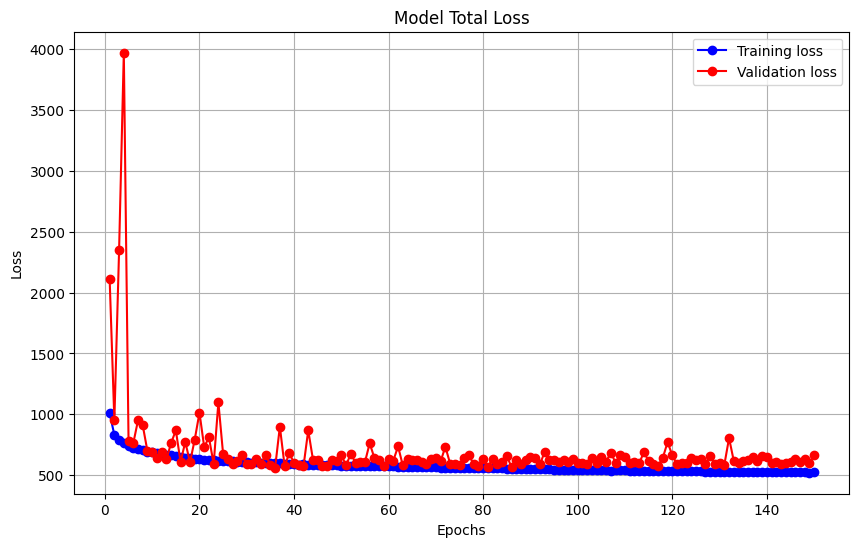

<Figure size 640x480 with 0 Axes>

In [19]:
def plot_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Model Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('../Current Models & Tensors/loss_plot.png')

# Assuming 'history' is the object returned by model.fit()
plot_losses(history)

Save models for inference

In [20]:
# Save encoder and decoder
encoder.save('../Current Models & Tensors/Models/cvae_encoder_model.keras')
decoder.save('../Current Models & Tensors/Models/cvae_decoder_model.keras')

# Create a dictionary with the parameters
params = {
    'Number of epochs': epochs,
    'Input width': input_width,
    'Input height': input_height,
    'Latent space dimensionality': hidden_dim,
    'Batch size': batch_size
}

# Save parameters to a JSON file
params_file_path = '../Current Models & Tensors/Models/cvae_parameters.json'
with open(params_file_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Models and parameters saved successfully.")

Models and parameters saved successfully.


Save latent space tensors for inference

In [21]:
mean_output = encoder.get_layer('mean').output
log_var_output = encoder.get_layer('log_var').output

encoder_latent_tensors = keras.Model(encoder.inputs, [mean_output, log_var_output], name="encoder_latent_tensors")

def save_latent_space_tensors(x_train, y_train, y_train_text, class_names, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # Create a mapping from class names to one-hot encoded labels
    label_to_onehot = {name: tf.keras.utils.to_categorical(i, num_classes=len(class_names)) 
                       for i, name in enumerate(class_names)}

    for class_name in class_names:
        # Filter data for this class
        class_mask = np.array(y_train_text) == class_name
        x_class = x_train[class_mask]
        
        # Create one-hot encoded labels for this class
        y_class_onehot = np.repeat(label_to_onehot[class_name][np.newaxis, :], x_class.shape[0], axis=0)

        # Generate latent tensors
        z_mean, z_log_var = encoder_latent_tensors.predict([x_class, y_class_onehot], batch_size=32)

        # Save tensors using class name
        np.save(os.path.join(save_dir, f"z_mean_{class_name}.npy"), z_mean)
        np.save(os.path.join(save_dir, f"z_log_var_{class_name}.npy"), z_log_var)

# Usage
save_dir = "../Current Models & Tensors/Latent Space Tensors"
save_latent_space_tensors(x_train, y_train, y_train_text, class_names, save_dir)

13/13 [==============================] - 1s 44ms/step
